#Table of Contents
* [Define a normalized fft for real valued arrays](#Define-a-normalized-fft-for-real-valued-arrays)
* [Refresher on powers of 2, especially large numbers](#Refresher-on-powers-of-2,-especially-large-numbers)
* [Make a noise array and play around with it](#Make-a-noise-array-and-play-around-with-it)
	* [Take average of every 10 points and compare statistics of resulting values with statistics of noise4096_lp!](#Take-average-of-every-10-points-and-compare-statistics-of-resulting-values-with-statistics-of-noise4096_lp!)


In [1]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from __future__ import print_function
import scipy.stats as ss

# Define a normalized fft for real valued arrays

Use numpy.fft.rfft, which takes an array with N real values (N is a power of 2) and returns an array with N/2 + 1 complex values. This represents the DC and positive frequency values of the Fourier transform of the original array. Since the original array is real, the negative frequency values of the Fourier transform are just the complex conjugate of the positive frequency values.

The normalized Fourier transform is just (2/N) times the original Fourier transform.

Define a function that returns the magnitude of the normalized Fourier transform.

In [9]:
def fft_norm_mag(a):
    normalization = 2.0 / len(a)
    return np.absolute(normalization * np.fft.rfft(a))

#Refresher on powers of 2, especially large numbers

In [3]:
num_pow_2 = []
for i in range(22):
    num_pow_2.append(pow(2,i))
    print(i, num_pow_2[i])

0 1
1 2
2 4
3 8
4 16
5 32
6 64
7 128
8 256
9 512
10 1024
11 2048
12 4096
13 8192
14 16384
15 32768
16 65536
17 131072
18 262144
19 524288
20 1048576
21 2097152


# Make a noise array and play around with it

In [4]:
noise4096 = np.random.normal(0,1,4096)

In [5]:
ss.describe(noise4096)

DescribeResult(nobs=4096, minmax=(-3.745301468657261, 3.6326792436729396), mean=0.015138908991248026, variance=1.0111371462316727, skewness=-0.026558745377963128, kurtosis=0.09888182753801278)

In [10]:
noise4096fft = fft_norm_mag(noise4096)

In [11]:
noise4096fft.shape

(2049,)

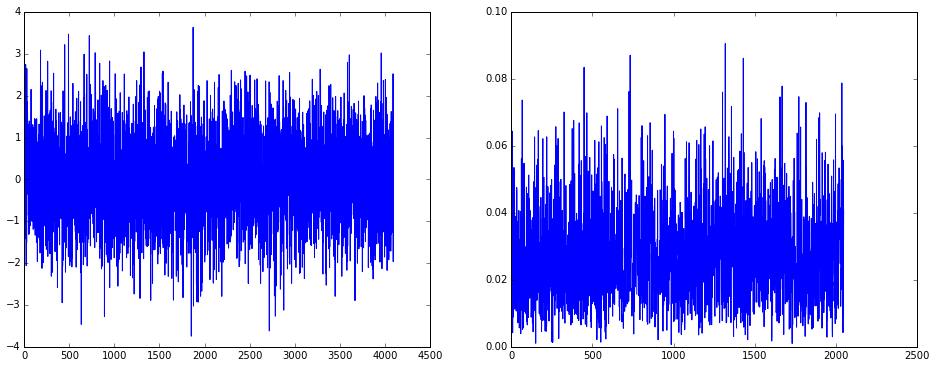

In [12]:
fig, (ax, axfft) = plt.subplots(1,2, figsize=(16,6))
ax.plot(noise4096)
axfft.plot(noise4096fft);

In [13]:
def fir_on_value_in_array(data_array, ii, h):
    '''Calculate FIR filtered value given filter coefficients, array of data, & current index into array of data
    
       Inputs:
           data_array - array of data values
           ii - index current data_array value for which to calculate filtered value
           h - array of filter coefficients
       Returns:
           new filtered value'''
    num_coef = len(h)
    accum = 0
    for k in range(num_coef):
        accum += h[k] * data_array[ii-k]
    return accum

def zero_phase_fir_on_array(data_array, h):
    '''Apply zero-phase FIR filter to array of data given the FIR filter coefficients. Zero-phase in practice
       means that the filtered data is shifted back in time in the output array by (N-1)/2 where N is the
       number of FIR filter coefficients. N must be odd. The first and last (N-1)/2 - 1 values of the filtered
       data array will be zero. 
    
       Inputs:
           data_array - array of data values to be filtered
           h - array of filter coefficients
       Returns:
           array with filtered values'''
    n_total_samples = len(data_array)
    filtered_data = np.zeros(n_total_samples)
    n_coef = len(h)
    n_mid_coef = (n_coef-1)//2
    for i in range(n_coef-1, n_total_samples):
        filtered_data[i-n_mid_coef] = fir_on_value_in_array(data_array, i, h)
    return filtered_data

def gain_magn(h, omega):
    '''Calculate gain of FIR filter with coefficients in array h and at normalized frequency omega.
       The coefficient array should be symmetric and the normalized frequency is f_desired/f_sampling.'''
    cos_term, sin_term = 0.0, 0.0
    for k in range(len(h)):
        cos_term += h[k] * np.cos(2.0*np.pi*omega*k)
        sin_term += h[k] * np.sin(2.0*np.pi*omega*k)
    gain_mag = np.sqrt( cos_term**2 + sin_term**2 )
    return gain_mag


Assume 10 kHz sampling rate and set low pass filter cutoff to 100 Hz and 20 Hz, respectively. 

In [14]:
lp_coef = [0.000326, 0.000692, 0.001207, 0.001891, 0.002756, 
           0.003806, 0.005036, 0.006430, 0.007961, 0.009591, 
           0.011275, 0.012958, 0.014582, 0.016086, 0.017413, 
           0.018507, 0.019325, 0.019829, 0.020000, 0.019829, 
           0.019325, 0.018507, 0.017413, 0.016086, 0.014582, 
           0.012958, 0.011275, 0.009591, 0.007961, 0.006430, 
           0.005036, 0.003806, 0.002756, 0.001891, 0.001207, 0.000692, 0.000326]

lp20Hz_coef = [0.000081, 0.000167, 0.000286, 0.000438, 0.000626, 
               0.000849, 0.001105, 0.001390, 0.001697, 0.002020, 
               0.002349, 0.002674, 0.002984, 0.003269, 0.003518, 
               0.003723, 0.003875, 0.003968, 0.004000, 0.003968, 
               0.003875, 0.003723, 0.003518, 0.003269, 0.002984, 
               0.002674, 0.002349, 0.002020, 0.001697, 0.001390, 
               0.001105, 0.000849, 0.000626, 0.000438, 0.000286, 0.000167, 0.000081] 

lp_coef_norm = lp_coef/gain_magn(lp_coef, 0.0)
lp20Hz_coef_norm = lp20Hz_coef/gain_magn(lp20Hz_coef, 0.0)

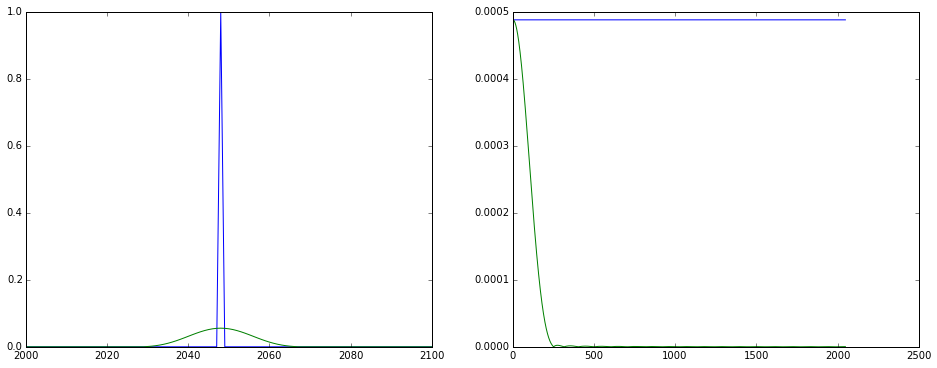

In [16]:
impulse_signal = np.zeros(len(noise4096))
impulse_signal[len(impulse_signal)/2] = 1.0
impulse_signal_lp = zero_phase_fir_on_array(impulse_signal, lp_coef_norm)
impulse_signalfft = fft_norm_mag(impulse_signal)
impulse_signal_lpfft = fft_norm_mag(impulse_signal_lp)
fig, (ax, axfft) = plt.subplots(1,2, figsize=(16,6))
ax.plot(impulse_signal)
ax.plot(impulse_signal_lp)
axfft.plot(impulse_signalfft)
axfft.plot(impulse_signal_lpfft)
#axfft.set_ylim(0,1.1)
ax.set_xlim(2000,2100)
#axfft.set_xlim(-2,50);

In [17]:
noise4096_lp = zero_phase_fir_on_array(noise4096, lp_coef_norm)
noise4096_lpfft = fft_norm_mag(noise4096_lp)

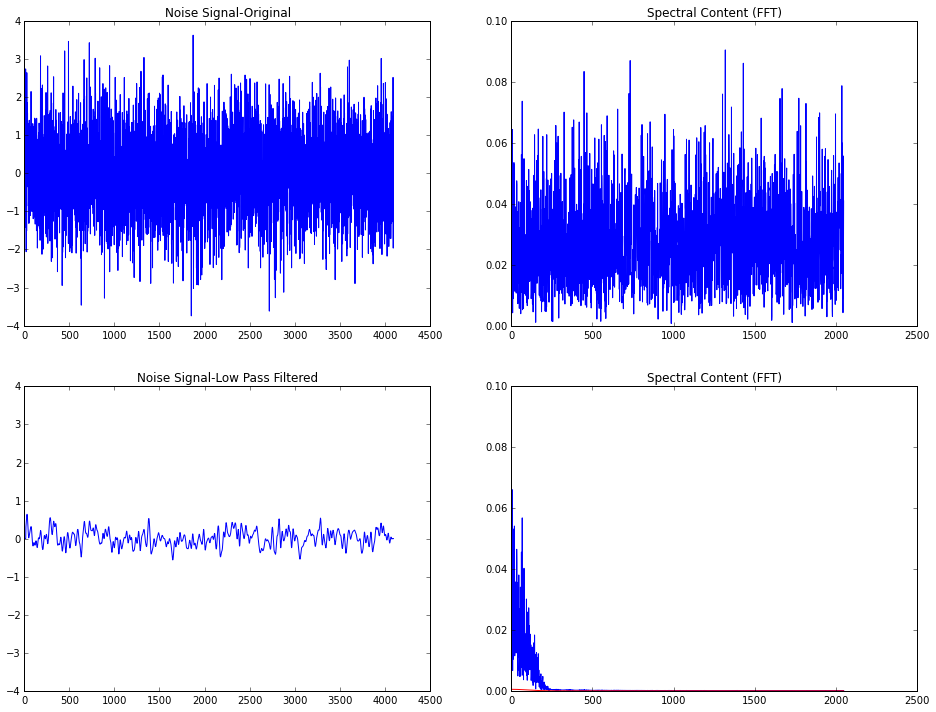

In [45]:
fig, ([ax, axfft], [axlp, axlpfft]) = plt.subplots(2,2, figsize=(16,12))
ax.plot(noise4096)
axfft.plot(np.absolute(noise4096fft))
axlp.plot(noise4096_lp)
axlpfft.plot(noise4096_lpfft)
axlpfft.plot(impulse_signal_lpfft, 'r')
ax.set_title('Noise Signal-Original')
axfft.set_title('Spectral Content (FFT)')
axlp.set_title('Noise Signal-Low Pass Filtered')
axlpfft.set_title('Spectral Content (FFT)')
axfft.set_ylim(0.0,0.1)
axlpfft.set_ylim(0.0,0.1)
ax.set_ylim(-4,4)
axlp.set_ylim(-4,4);

In [19]:
temp_start, delta = 10, 60
print(noise4096fft[temp_start:temp_start+delta], '\n')
print(noise4096_lpfft[temp_start:temp_start+delta])

[ 0.05153846  0.04480796  0.00885092  0.01844047  0.03176873  0.0218054
  0.02831873  0.05355351  0.04425643  0.02316641  0.05287479  0.0399194
  0.01350781  0.01125469  0.03590599  0.02656006  0.03898808  0.03336894
  0.01754118  0.03708248  0.01876387  0.01067243  0.01898247  0.0188448
  0.04756231  0.04629259  0.01378623  0.0374493   0.0176415   0.01919425
  0.01291366  0.0072001   0.02099164  0.03032511  0.01387663  0.01585904
  0.02836963  0.04070234  0.0307025   0.02251353  0.00564859  0.01312151
  0.0197213   0.00712973  0.03003078  0.03213664  0.00747408  0.04039203
  0.02566478  0.0038952   0.01963825  0.03475105  0.01089779  0.05618768
  0.02401168  0.01665305  0.01609246  0.01569739  0.07370917  0.01505643] 

[ 0.04962851  0.04391832  0.01035709  0.01758726  0.02905266  0.02332962
  0.02701789  0.05318917  0.04177287  0.02308347  0.05412747  0.03813129
  0.01149626  0.01326789  0.03442781  0.02440889  0.03576232  0.02986085
  0.0181384   0.03398142  0.01657503  0.01244596  0

In [20]:
print(ss.describe(noise4096), '\n')
print(ss.describe(noise4096[:409]), '\n')
print(ss.describe(noise4096_lp))

DescribeResult(nobs=4096, minmax=(-3.745301468657261, 3.6326792436729396), mean=0.015138908991248026, variance=1.0111371462316727, skewness=-0.026558745377963128, kurtosis=0.09888182753801278) 

DescribeResult(nobs=409, minmax=(-2.5834861662253559, 3.0889970672825164), mean=0.094258104001636547, variance=0.95092589599357558, skewness=0.11581917831456892, kurtosis=-0.08605488497879366) 

DescribeResult(nobs=4096, minmax=(-0.55997756823259193, 0.63944986155515993), mean=0.013874807403150377, variance=0.040072764517811429, skewness=0.02116840453328955, kurtosis=-0.08117838552731849)


##Take average of every 100 points and compare statistics of resulting values with statistics of noise4096_lp!

In [22]:
noise4096_ave100pts = []
for i in range(4096//100 + 1):
    noise4096_ave100pts.append(sum(noise4096[i*100:(i+1)*100])/100)
    print(i, noise4096_ave100pts[i])

0 0.209353763283
1 -0.0670563566847
2 0.125360759305
3 0.0893519402398
4 -0.0678403998402
5 0.00905989450189
6 0.0251636164352
7 0.252223935099
8 0.0352000361114
9 -0.0026493613176
10 -0.128555471701
11 0.0325362919387
12 -0.139299907497
13 0.126356320147
14 -0.13135977653
15 -0.0462071679671
16 -0.182449935234
17 0.00542963191686
18 -0.148981071937
19 -0.0126557254569
20 -0.0864135995947
21 -0.071864935356
22 0.134701679996
23 0.20941611321
24 0.155131106215
25 0.143858835387
26 -0.222037834008
27 -0.128020121102
28 0.0819087695069
29 0.138514025689
30 -0.180814770969
31 0.0635714196685
32 0.132788891695
33 0.0165133680236
34 0.101528161656
35 -0.0847170135809
36 0.111542708841
37 -0.0786844238675
38 -0.0836002848733
39 0.223599915889
40 0.060186685043


(-4, 4)

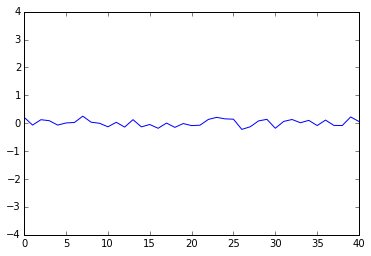

In [46]:
plt.plot(noise4096_ave100pts)
plt.ylim(-4,4)

In [25]:
print(ss.describe(noise4096), '\n')
print(ss.describe(noise4096[:409]), '\n')
print(ss.describe(noise4096_lp), '\n')
print(ss.describe(noise4096_ave100pts))

DescribeResult(nobs=4096, minmax=(-3.745301468657261, 3.6326792436729396), mean=0.015138908991248026, variance=1.0111371462316727, skewness=-0.026558745377963128, kurtosis=0.09888182753801278) 

DescribeResult(nobs=409, minmax=(-2.5834861662253559, 3.0889970672825164), mean=0.094258104001636547, variance=0.95092589599357558, skewness=0.11581917831456892, kurtosis=-0.08605488497879366) 

DescribeResult(nobs=4096, minmax=(-0.55997756823259193, 0.63944986155515993), mean=0.013874807403150377, variance=0.040072764517811429, skewness=0.02116840453328955, kurtosis=-0.08117838552731849) 

DescribeResult(nobs=41, minmax=(-0.2220378340079889, 0.25222393509852192), mean=0.015124139323939488, variance=0.015579769607081986, skewness=0.009617231003753602, kurtosis=-0.99498666701761)


In [29]:
desc = ss.describe(noise4096_ave100pts)
desc

DescribeResult(nobs=41, minmax=(-0.2220378340079889, 0.25222393509852192), mean=0.015124139323939488, variance=0.015579769607081986, skewness=0.009617231003753602, kurtosis=-0.99498666701761)

In [43]:
desc = ss.describe(noise4096_ave100pts)

names = ["length", "   min", "   max", "  mean", " stdev"]
desc = [desc[0], desc[1][0], desc[1][1], desc[2], np.sqrt(desc[3])]

for i in range(5):
    print("%s: %f" % (names[i], desc[i]))

length: 41.000000
   min: -0.222038
   max: 0.252224
  mean: 0.015124
 stdev: 0.124819


In [42]:
desc = ss.describe(noise4096)

names = ["length", "   min", "   max", "  mean", " stdev"]
desc = [desc[0], desc[1][0], desc[1][1], desc[2], np.sqrt(desc[3])]

for i in range(5):
    print("%s: %f" % (names[i], desc[i]))

length: 4096.000000
   min: -3.745301
   max: 3.632679
  mean: 0.015139
 stdev: 1.005553


In [41]:
desc = ss.describe(noise4096_lp)

names = ["length", "   min", "   max", "  mean", " stdev"]
desc = [desc[0], desc[1][0], desc[1][1], desc[2], np.sqrt(desc[3])]

for i in range(5):
    print("%s: %f" % (names[i], desc[i]))

length: 4096.000000
   min: -0.559978
   max: 0.639450
  mean: 0.013875
 stdev: 0.200182
